In [ ]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score, classification_report, roc_curve, auc
from sklearn.utils import resample

import tensorflow as tf
from tensorflow import keras
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.config.list_physical_devices('GPU'))

In [ ]:
!pip install pyrsgis
!pip install matplotlib_scalebar
from pyrsgis import raster
from pyrsgis.convert import array_to_table

In [ ]:
main_bands = [i+1 for i in range(0,7)]
ndvi_band = 9
labels_band = 8

# choose the input band(s)
# input_bands = ndvi_band
input_bands = main_bands

print('Analyzing bands: ', input_bands)

# store the number of bands, which will be useful for inputting to the neural network later
if input_bands == ndvi_band: nBands = 1
else: nBands = len(main_bands)
print('nBands: ', nBands)


downsampleMajority = False

Analyzing bands:  [1, 2, 3, 4, 5, 6, 7]
nBands:  7


In [ ]:
def removeOuterEdges(x):
    '''Something is off with the top row in the satellite data, and sometimes the other edges, remove them.'''
    if x.ndim == 2:
        x = np.delete(x, [0, x.shape[0]-1], axis=0) # remove top and bottom edges
        x = np.delete(x, [0, x.shape[1]-1], axis=1) # remove left and right edges
    else:
        x = np.delete(x, [0, x.shape[1]-1], axis=1) # remove top and bottom edges
        x = np.delete(x, [0, x.shape[2]-1], axis=2) # remove left and right edges

    return x

def normalizeBand(band):
    '''normalize band inputs to 0-1 for input into neural nets'''
    band_min, band_max = band.min(), band.max()
    return ((band - band_min)/(band_max - band_min))

def normalizeUInt16Band(band):
    '''Bands 1-7 are uint16, ranging from 0-65535, normalize them by dividing by the max.'''
    return band/65535.

In [ ]:
# methods related to plotting - should be moved out into a separate file

# define colormap for plots
discrete_cmap = mpl.colors.ListedColormap(["red", "cornflowerblue", "gold", "olivedrab"], name="discrete_cmap")
vmin=-1
vmax=2

def plotNVDIBand(input_data):
    plt.figure(figsize=(24,6))
    plt.imshow(input_data, cmap='RdYlGn', vmin=-1, vmax=1)
    plt.colorbar()
    plt.show()

def plotMangroveBand(input_data):
    plt.figure(figsize=(16,6))
    plt.imshow(input_data, cmap=discrete_cmap, vmin=vmin, vmax=vmax)
    # plt.colorbar()
    plt.show()

def plotDifference(labels_data, predicted_data):
    '''
    Plot difference in predicted (or future predicted) mangroves and labeled (past) mangroves.
    # multiply first array by 2 in order to get 4 values for difference plot:
    # pred - label -> output
    # 0 - 0 -> 0, predicted and label/past are not mangroves
    # 1 - 1 -> 1, predicted and label/past are mangroves
    # 1 - 0 -> 2, predicted was mangrove, label/past was not -> growth/false positive
    # 0 - 1 -> 0, predicted was not mangrove, label/past was -> loss/false negative
    '''

    image_difference = 2 * predicted_data - labels_data
    plt.figure(figsize=(24,6))
    plt.imshow(image_difference, cmap=discrete_cmap, vmin=vmin, vmax=vmax)
    plt.colorbar()
    plt.show()

In [ ]:
def printClassificationMetrics(y_actual, y_predicted_prob, input_prob=0.5):
    '''Print various classification metrics.'''

    y_predicted = (y_predicted_prob > input_prob).astype(int) # convert prediction probabilities to 0 or 1 values depending on threshold
    cMatrix = confusion_matrix(y_actual, y_predicted)
    pScore = precision_score(y_actual, y_predicted)
    rScore = recall_score(y_actual, y_predicted)
    aScore = accuracy_score(y_actual, y_predicted)
    f1Score = f1_score(y_actual, y_predicted)

    print("Confusion matrix:\n", cMatrix)
    print("\nP-Score: %.3f, R-Score: %.3f" % (pScore, rScore))
    print('Accuracy: %.3f' % (aScore))
    print('f1: %.3f' % (f1Score))

    print(classification_report(y_actual, y_predicted))

def makeROCPlot(y_actual, y_predicted_prob):
    fpr, tpr, thresholds = roc_curve(y_actual, y_predicted_prob)
    auc_score = auc(fpr, tpr)

    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label='AUC = {:.3f}'.format(auc_score))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show()

In [ ]:
# method for predicting on an image with the trained model
def predictOnImage(model, image):
  '''Take trained model and apply it to a new image.'''
  # read in band data
  ds_features_new, features_new = raster.read(image, bands=input_bands)
  ds_labels_new, labels_new = raster.read(image, bands=labels_band)

  # remove outer edges of data (which sometimes have issues)
  features_new = removeOuterEdges(features_new)
  labels_new = removeOuterEdges(labels_new)

  # fill NaNs with 0s
  features_new = np.nan_to_num(features_new)
  labels_new = np.nan_to_num(labels_new)

  # change label from float to int
  labels_new = (labels_new == 1).astype(int)

  # print('Check shapes:', features_new.shape, labels_new.shape)

  # plot NDVI band (if using it)
  if input_bands == ndvi_band:
    print('\nNDVI band:')
    plotNVDIBand(features_new)

  # plot Mangrove band
  print('\nLabel mangroves from 2000 data:')
  plotMangroveBand(labels_new)

  # change dimensions of input
  features_new_input = array_to_table(features_new)
  labels_new_input = array_to_table(labels_new)

  # reshape it as an additional step for input into the NN
  features_new_input = features_new_input.reshape((features_new_input.shape[0], 1, nBands))
  # print('Check transformed shapes:', features_new_input.shape, labels_new_input.shape)

  # normalize bands for new image if using the main bands
  if input_bands == main_bands:
    features_new_input = normalizeUInt16Band(features_new_input)

  # predict on new image
  predicted_new_image_prob = model.predict(features_new_input)
  predicted_new_image_prob = predicted_new_image_prob[:,1]

  # print classification metrics
  probThresh = 0.5
  printClassificationMetrics(labels_new_input, predicted_new_image_prob, probThresh)
  makeROCPlot(labels_new_input, predicted_new_image_prob)

  # reshape prediction into 2D for plotting
  predicted_new_image_aboveThresh = (predicted_new_image_prob > probThresh).astype(int)
  prediction_new_image_2d = np.reshape(predicted_new_image_aboveThresh, (ds_labels_new.RasterYSize-2, ds_labels_new.RasterXSize-2)) # need the -2s since I removed the outer edges

  # plot predicted mangroves
  print('\nPredicted mangroves:')
  plotMangroveBand(prediction_new_image_2d)

  # plot difference in predicted and labeled, or future vs past labeled
  print('\nDifference between predicted and labeled mangroves:')
  plotDifference(labels_new, prediction_new_image_2d)

In [ ]:
# method for loading multiple images as training data (with some portion set aside for testing data with same images)
def loadTrainingImages(images_list):
    '''Load images from list as training data, separately process each image and then concatenate the numpy arrays of training data.'''

    # initialize empty arrays which will concatenate data from all training images
    training_image_data = []
    training_image_labels = []

    for i, image in enumerate(images_list):
        # read in band data
        ds_features, features = raster.read(image, bands=input_bands)
        ds_labels, labels = raster.read(image, bands=labels_band)

        # remove outer edges of data (which sometimes have issues)
        # features = removeOuterEdges(features)
        # labels = removeOuterEdges(labels)

        # fill NaNs with 0s
        features = np.nan_to_num(features)
        labels = np.nan_to_num(labels)

        print('Feature shape: ', features.shape)

        # make some plots just for the first training image
        if i == 0:
            if input_bands == ndvi_band:
                print('\nFirst training image NDVI band:')
                plotNVDIBand(features) # plot NDVI band
            print('\nFirst training image mangroves from labels: ')
            plotMangroveBand(labels) # plot label (mangrove) band

        # change dimensions for input into neural net
        features_input = array_to_table(features)
        labels_input = array_to_table(labels)

        # convert labels to int for classification
        labels_input = (labels_input == 1).astype(int)

        # # Check the number of dimensions of the arrays
        # print('Number of dimensions of features_input:', features_input.ndim)
        # print('Number of dimensions of labels_input:', labels_input.ndim)

        # Ensure both arrays have the same number of dimensions
        if features_input.ndim != labels_input.ndim:
            # Reshape the labels to match the dimensions of features
            labels_input = labels_input.reshape(features_input.shape[:-1])

        # append image inputs together
        training_image_data.append(features_input)
        training_image_labels.append(labels_input)

    # Concatenate the lists of arrays into single arrays
    features = np.concatenate(training_image_data, axis=0)
    labels = np.concatenate(training_image_labels, axis=0)

    # check balance of classes
    training_data_length = len(features)
    print('Using training data of length: ', training_data_length)
    print(f"Class 0: {np.count_nonzero(labels==0)} Class 1: {np.count_nonzero(labels==1)}")
    print(f"Class 0: {100 * np.count_nonzero(labels==0)/training_data_length : .1f}% Class 1: {100 * np.count_nonzero(labels==1)/training_data_length : .1f}%")

    return features, labels


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
ndvi_1999_file_path = '/content/drive/My Drive/NDVI_Images/NDVI_1999.tif'
ndvi_2004_file_path = '/content/drive/My Drive/NDVI_Images/NDVI_2004.tif'
ndvi_2009_file_path = '/content/drive/My Drive/NDVI_Images/NDVI_2009.tif'
ndvi_2014_file_path = '/content/drive/My Drive/NDVI_Images/NDVI_2014.tif'
ndvi_2019_file_path = '/content/drive/My Drive/NDVI_Images/NDVI_2019.tif'

Feature shape:  (2414, 2559)

First training image mangroves from labels: 


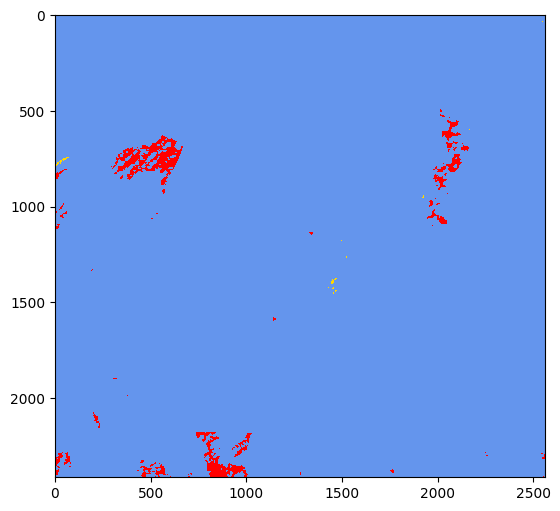

Feature shape:  (2414, 2559)
Feature shape:  (2414, 2559)
Feature shape:  (2414, 2559)
Using training data of length:  24709704
Class 0: 24709704 Class 1: 0
Class 0:  100.0% Class 1:  0.0%


In [ ]:
training_images = []
# append images individually so I can test what happens when I mix up the training data - later on will probably want to glob image paths from the source directory
training_images.append(ndvi_1999_file_path)
training_images.append(ndvi_2004_file_path)
training_images.append(ndvi_2009_file_path)
training_images.append(ndvi_2014_file_path)
# training_images.append(ndvi_2019_file_path)


model_input_data, model_input_labels = loadTrainingImages(training_images)

In [ ]:
# Print some additional information about the data
print("Number of bands:", nBands)
print("Size of xTrain:", xTrain.size)
print("Size of xTest:", xTest.size)

Number of bands: 7
Size of xTrain: 14825822
Size of xTest: 9883882


In [ ]:
expected_size_train = xTrain.shape[0] * nBands
expected_size_test = xTest.shape[0] * nBands

print("Expected size of xTrain:", expected_size_train)
print("Expected size of xTest:", expected_size_test)

Expected size of xTrain: 103780754
Expected size of xTest: 69187174


In [ ]:
print("Shape of model_input_data:", model_input_data.shape)
print("Shape of model_input_labels:", model_input_labels.shape)


Shape of model_input_data: (24709704,)
Shape of model_input_labels: (24709704,)


In [ ]:
# Split the data
xTrain, xTest, yTrain, yTest = train_test_split(model_input_data, model_input_labels, test_size=0.4, random_state=42, stratify=model_input_labels, shuffle=True)

print(xTrain.shape)
print(yTrain.shape)
print(xTest.shape)
print(yTest.shape)

# Reshape input data for neural network
xTrain = xTrain[:, 0, :]
xTest = xTest[:, 0, :]

print(xTrain.shape)
print(xTest.shape)

(14825822, 1, 1)
(14825822, 1)
(9883882, 1, 1)
(9883882, 1)
(14825822, 1)
(9883882, 1)


In [ ]:
# normalize bands - don't really need to do this for the NDVI band, and probably want to use something separate for the other bands, which are already by default bounded
# probably also do not want to normalize differently between the train and test, since their bounds are independent of the samples
# xTrain = normalizeBand(xTrain)
# xTest = normalizeBand(xTest)

# normalize main bands
if input_bands == main_bands:
  xTrain = normalizeUInt16Band(xTrain)
  xTest = normalizeUInt16Band(xTest)

In [ ]:
if input_bands == ndvi_band:
  model = keras.Sequential([
      keras.layers.Flatten(input_shape=(1, nBands)),
      # keras.layers.Dense(10, activation='relu'),
      keras.layers.Dense(10, activation='relu'),
      keras.layers.Dense(2, activation='softmax')])
else:
  model = keras.Sequential([
    keras.layers.Flatten(input_shape=(1, nBands)),
    keras.layers.Dense(14, activation='relu'),
    keras.layers.Dense(14, activation='relu'),
    keras.layers.Dense(2, activation='softmax')])

# Define the accuracy metrics and parameters
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

print(model.summary)

<bound method Model.summary of <keras.src.engine.sequential.Sequential object at 0x787987c12050>>


In [ ]:
print("Shape of xTrain:", xTrain.shape)
print("Shape of yTrain:", yTrain.shape)

Shape of xTrain: (14825822,)
Shape of yTrain: (14825822, 1)


In [ ]:
yTrain = yTrain.reshape(-1)
print("New shape of yTrain:", yTrain.shape)

New shape of yTrain: (14825822,)


In [ ]:
print("Shape of xTrain:", xTrain.shape)
print("Shape of xTest:", xTest.shape)

Shape of xTrain: (14825822,)
Shape of xTest: (9883882,)
